In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from pandas.tseries.offsets import MonthEnd

In [2]:
df = pd.read_csv('bitcoin.csv',delimiter='|', engine='python')

In [3]:
df = df[245:]
df = pd.DataFrame(df, columns=['Date', 'Google Trending', 'Open', 'High', 'Low', 'Volume', 'Cap', 'Close'])

df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [4]:
df.head()

,Google Trending,Open,High,Low,Volume,Cap,Close
Date,,,,,,,
2013-12-29,26,728.05,748.61,714.44,19011300,8872600000,745.05
2013-12-30,27,741.35,766.60,740.24,20707700,9037000000,756.13
2013-12-31,26,760.32,760.58,738.17,20897300,9268240000,754.01
2014-01-01,29,754.97,775.35,754.97,22489400,9203030000,771.40
2014-01-02,32,773.44,820.31,767.21,38489500,9428180000,802.39


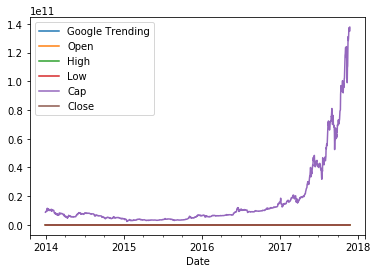

In [5]:
df.plot()

In [6]:
split_date = pd.Timestamp('01-01-2017')

In [7]:
train = df.loc[:split_date, ['Google Trending', 'Open', 'High', 'Low', 'Volume', 'Cap', 'Close']]
test = df.loc[split_date:, ['Google Trending', 'Open', 'High', 'Low', 'Volume', 'Cap', 'Close']]

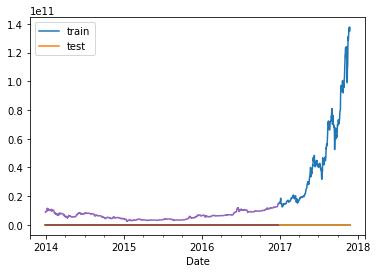

In [8]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [9]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

train_sc

array([[ 0.15909091,  0.69046515,  0.66660872, ...,  0.04481309,
         0.48668534,  0.69120856],
       [ 0.17045455,  0.70712702,  0.68894573, ...,  0.04951926,
         0.49910022,  0.70471697],
       [ 0.15909091,  0.7308921 ,  0.68147109, ...,  0.05004525,
         0.51656262,  0.70213233],
       ..., 
       [ 0.78409091,  0.99674279,  0.94463552, ...,  0.51216375,
         0.99699445,  0.95478098],
       [ 0.65909091,  0.98183481,  0.93372155, ...,  0.26709322,
         0.98268411,  0.9578289 ],
       [ 0.04545455,  0.98563071,  0.98256745, ...,  0.40203045,
         0.98649768,  1.        ]])

In [31]:
def preprocess_data(data, seq_len):
    amount_of_features = len(data[0])
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    
    X_data = result[:, : -1]
    y_data = result[:, -1][: ,-1]

    X_data = np.reshape(X_data, (X_data.shape[0], X_data.shape[1], amount_of_features))

    return [X_data, y_data]

In [33]:
X_train, y_train = preprocess_data(train_sc, 30)
X_test, y_test = preprocess_data(test_sc, 30)

In [34]:
X_train.shape

(1069, 30, 7)

In [35]:
X_test.shape

(298, 30, 7)

# Model

In [41]:
import time
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers.core import Dense, Dropout, Activation

import keras.backend as K 

from keras.callbacks import EarlyStopping 

def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(30, return_sequences=True, input_shape=(layers[1], layers[2])))
    model.add(Dropout(0.4))

    model.add(LSTM(
        100,
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(1))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [42]:
model = build_model(X_train.shape)

('Compilation Time : ', 0.019186019897460938)


In [44]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(
    X_train,
    y_train,
    batch_size=30,
    epochs=100,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stop])

Train on 962 samples, validate on 107 samples
Epoch 1/100
962/962 [==============================] - 2s 2ms/step - loss: 0.0093 - acc: 0.0010 - val_loss: 0.0199 - val_acc: 0.0000e+00
Epoch 2/100
962/962 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 0.0010 - val_loss: 0.0139 - val_acc: 0.0000e+00
Epoch 3/100
962/962 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 0.0010 - val_loss: 0.0084 - val_acc: 0.0000e+00
Epoch 4/100
962/962 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 0.0010 - val_loss: 0.0086 - val_acc: 0.0000e+00
Epoch 5/100
962/962 [==============================] - 1s 1ms/step - loss: 0.0033 - acc: 0.0010 - val_loss: 0.0094 - val_acc: 0.0000e+00
Epoch 6/100
962/962 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 0.0010 - val_loss: 0.0091 - val_acc: 0.0000e+00
Epoch 00006: early stopping


In [47]:
import math

trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00 MSE (0.05 RMSE)
Test Score: 8.77 MSE (2.96 RMSE)


# Predict

In [53]:
y_pred = model.predict(X_test)

In [78]:
b = np.array(test)

In [83]:
x, y = preprocess_data(b, 30)

In [86]:
test_y = model.predict(x)

In [87]:
test_y

array([[-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0.08181676],
       [-0